In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from covid_loader.covid_loader import *

In [3]:
%%time
ds_train = USCasesDataset(root = "./data", download = False, 
                          Province_State= ["California"], 
                          remove_negative_days = True,
                          date_range=(None, pd.to_datetime("2020-08-01")))


ds_valid = USCasesDataset(root = "./data", download = False, 
                          Province_State= ["California"], 
                          remove_negative_days = True,
                          date_range=(pd.to_datetime("2020-08-02"), 
                                      pd.to_datetime("2020-08-10")))


ds_test = USCasesDataset(root = "./data", download = False, 
                         Province_State= ["California"], 
                         remove_negative_days = True,
                         date_range=(pd.to_datetime("2020-08-11"),
                                     None))


CPU times: user 18.3 s, sys: 1.03 s, total: 19.3 s
Wall time: 19.3 s


In [4]:
len(ds_train), len(ds_valid), len(ds_test)

(55, 55, 55)

In [5]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return [data, target]

In [6]:
tr_loader = DataLoader(ds_train, num_workers=0, batch_size = 1,
                            collate_fn=my_collate)


vl_loader = DataLoader(ds_valid, num_workers=0, batch_size = 1,
                            collate_fn=my_collate)

ts_loader = DataLoader(ds_test, num_workers=0, batch_size = 1,
                            collate_fn=my_collate)

In [7]:
def prep_data(input_df):
    weekend = (((input_df["date"].dt.dayofweek == 5) | 
                (input_df["date"].dt.dayofweek == 6)).
               astype(int).values[:,np.newaxis])
    geo = input_df[["Lat", "Long_"]].values
    with np.errstate(all='ignore'):
        case_stats = np.log10(1.1+input_df[["num_cases", 
                                            "num_days", 
                                            "new_cases"]]).fillna(-1)

    features = np.hstack((case_stats, geo, weekend))
    
    X = torch.tensor(features[:-1,:], dtype = torch.float32)
    y = torch.tensor(np.log10(1+ input_df[["num_cases"]].values)[1:,:],
                     dtype = torch.float32)
    
    return X, y

In [8]:
from torch import nn
import torch.nn.functional as F

import torch

class TorchRidge:
    def __init__(self, alpha = 0, fit_intercept = True):
        self.alpha = alpha
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = torch.cat([torch.ones(X.shape[0], 1), X], dim = 1)
        # Solving Xw = y with Normal equations:
        # X^{T}Xw = X^{T}y 
        lhs = X.T @ X 
        rhs = X.T @ y
        if self.alpha == 0:
            self.w, _ = torch.lstsq(rhs, lhs)
        else:
            ridge = self.alpha*torch.eye(lhs.shape[0])
            self.w, _ = torch.lstsq(rhs, lhs + ridge)
    def predict(self, X):
        if self.fit_intercept:
            X = torch.cat([torch.ones(X.shape[0], 1), X], dim = 1)
        return X @ self.w

In [9]:
losses = {}
for tr_item, vl_item, ts_item in zip(tr_loader, vl_loader, ts_loader):
    if tr_item[1][0].shape[0] < 5:
        continue
    X_tr, y_tr = prep_data(tr_item[1][0])
    X_vl, y_vl = prep_data(vl_item[1][0])
    X_ts, y_ts = prep_data(ts_item[1][0])

    model = TorchRidge(alpha = 1e-3)
    model.fit(X_tr, y_tr)

    tr_loss = torch.nn.functional.l1_loss(model.predict(X_tr), y_tr).item()
    vl_loss = torch.nn.functional.l1_loss(model.predict(X_vl), y_vl).item()
    ts_loss = torch.nn.functional.l1_loss(model.predict(X_ts), y_ts).item()
    
    losses[tr_item[0][0]] = [tr_loss, vl_loss, ts_loss]

In [10]:
df_losses = pd.DataFrame.from_dict(losses, orient = "index", 
                                   columns = ["train", "valid", "test"])

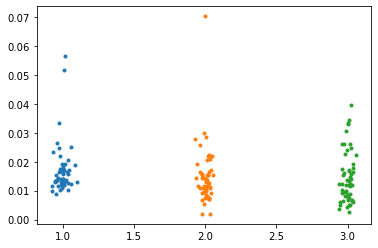

In [11]:
plt.plot(np.ones(df_losses.shape[0]) + .03*np.random.randn(df_losses.shape[0]), 
         df_losses.iloc[:,0], '.')
plt.plot(2*np.ones(df_losses.shape[0]) + .03*np.random.randn(df_losses.shape[0]), 
         df_losses.iloc[:,1], '.')
plt.plot(3*np.ones(df_losses.shape[0]) + .03*np.random.randn(df_losses.shape[0]), 
         df_losses.iloc[:,2], '.')